# Statistical tests
A notebook to perform tests using the Cox Proportional Hazard model to select features and covariates that influence survival

In [1]:
import Abed_utils
import os
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import numpy as np
from scipy.stats import chisquare, ttest_ind
import seaborn as sns

In [2]:
full_df = pd.read_csv('metadata/full_df.csv')
full_df.head()

,Unnamed: 0,patient_id,gender,age,diagnosis,location_specific,location,pt,pt_group,pn,...,tsr_q25,tsr_q50,tsr_q75,tsr_mean,tsr_est_q25,tsr_est_q50,tsr_est_q75,tsr_est_mean,tsr,roi_tsr
0,0,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,...,0.936087,0.976751,0.990994,0.955028,0.824026,0.876453,0.924482,0.872773,0.760542,0.752743
1,1,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,...,0.940220,0.971893,0.986070,0.930820,0.771250,0.823717,0.877430,0.820560,0.701752,0.543471
2,4,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,...,0.022578,0.054593,0.540306,0.279577,0.394779,0.487238,0.608896,0.509430,0.209621,0.538775
3,5,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,...,0.063587,0.150189,0.607203,0.332216,0.457595,0.509831,0.598535,0.512643,0.272062,0.133610
4,6,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,...,0.017364,0.042972,0.115521,0.130877,0.419876,0.474648,0.515490,0.466747,0.102042,0.095680


In [3]:
full_df.dtypes

Unnamed: 0             int64
patient_id             int64
gender                object
age                  float64
diagnosis             object
location_specific     object
location              object
pt                    object
pt_group              object
pn                    object
pn_group              object
pm                    object
tnm                   object
tnm_group             object
os                   float64
os_event              object
dfs                  float64
dfs_event             object
g                     object
l                     object
v                     object
tbc                  float64
prior_treatment       object
post_treatment        object
tissue_type           object
slide_filename        object
slide_path            object
slide_position        object
slide_size           float64
tsr_path              object
tsr_cls_path          object
tsr_q25              float64
tsr_q50              float64
tsr_q75              float64
tsr_mean      

In [4]:
relevant_cols = ['tsr', 'roi_tsr', 'pm', 'pn_group', 'pt_group', 'tnm_group', 'os', 'os_event', 'patient_id', 'tbc']
df = full_df[relevant_cols].copy()
thresh = 50
# df['tbc'] = (df.tbc > thresh).map({True:f'0-{thresh}', False:f'{thresh+1}-100'})
df['tbc'] = pd.cut(df.tbc, 2)
df.head()

,tsr,roi_tsr,pm,pn_group,pt_group,tnm_group,os,os_event,patient_id,tbc
0,0.760542,0.752743,pm0,pn0,pt012,tnm012,34.944116,alive,3,"(-0.1, 50.0]"
1,0.701752,0.543471,pm0,pn0,pt012,tnm012,34.944116,alive,3,"(-0.1, 50.0]"
2,0.209621,0.538775,pm0,pn12,pt34,tnm34,75.542406,alive,6,"(-0.1, 50.0]"
3,0.272062,0.133610,pm0,pn12,pt34,tnm34,75.542406,alive,6,"(-0.1, 50.0]"
4,0.102042,0.095680,pm0,pn12,pt34,tnm34,75.542406,alive,6,"(-0.1, 50.0]"


In [5]:
for id, group in df.drop(['tsr', 'roi_tsr'], axis=1).dropna().groupby('patient_id'):
    if group.shape[0] == 1:
        continue
    for _, row in group.iloc[1:,:].iterrows():
        if (row != group.iloc[0,:]).any():
            raise RuntimeError(f'{row} != {group.iloc[0,:]}')
print('All values other than TSR are consistent per patient, we can safely aggregate TSR across slides!')

All values other than TSR are consistent per patient, we can safely aggregate TSR across slides!


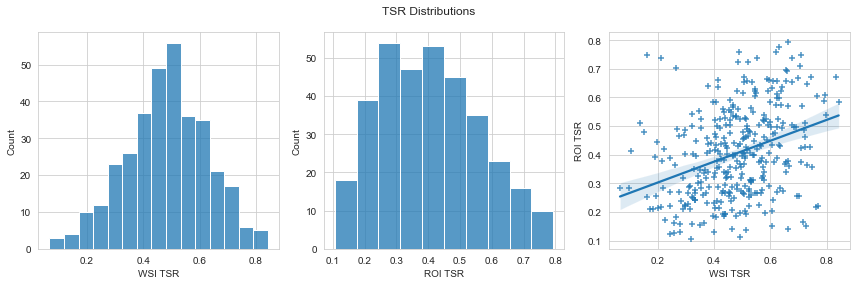

,tsr,roi_tsr
patient_id,,
3,0.731147,0.648107
6,0.194575,0.256021
10,0.545239,0.623737
12,0.453048,0.268279
14,0.409665,0.354456


In [6]:
tsr_agg = df[['patient_id', 'tsr', 'roi_tsr']].groupby('patient_id').mean()
fig, axs = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('TSR Distributions')
sns.histplot(data=tsr_agg, x='tsr', ax=axs[0])
axs[0].set_xlabel('WSI TSR')
sns.histplot(data=tsr_agg, x='roi_tsr', ax=axs[1])
axs[1].set_xlabel('ROI TSR')
sns.regplot(data=tsr_agg, x='tsr', y='roi_tsr', ax=axs[2], marker='+')
axs[2].set_xlabel('WSI TSR')
axs[2].set_ylabel('ROI TSR')
# fig.suptitle('TSR Distributions')
plt.tight_layout()
plt.savefig('figures/TSR_distribution.pdf')
plt.show()
tsr_agg.head()

In [7]:
df = df.join(tsr_agg, on='patient_id', rsuffix='_agg').drop(['tsr', 'roi_tsr', 'patient_id'], axis=1).drop_duplicates()
tsr_thresh = 0.5
df['tsr_agg'] = (df.tsr_agg >= tsr_thresh).map({True:'High', False:'Low'})
df['roi_tsr_agg'] = (df.roi_tsr_agg >= tsr_thresh).map({True:'High', False:'Low'})
print(f'After dropping duplicates, we are left with {df.shape[0]} entries')
df.head()

After dropping duplicates, we are left with 340 entries


,pm,pn_group,pt_group,tnm_group,os,os_event,tbc,tsr_agg,roi_tsr_agg
0,pm0,pn0,pt012,tnm012,34.944116,alive,"(-0.1, 50.0]",High,High
2,pm0,pn12,pt34,tnm34,75.542406,alive,"(-0.1, 50.0]",Low,Low
5,pm0,pn0,pt012,tnm012,1.775148,dead,"(-0.1, 50.0]",High,High
8,pm0,pn0,pt34,tnm012,1.775148,alive,"(-0.1, 50.0]",Low,Low
10,pm0,pn0,pt34,tnm012,49.671269,alive,"(-0.1, 50.0]",Low,Low


We encode the binary variables to 0 and 1

In [8]:
encoders = {}
cat_cols = ['pm', 'pn_group', 'pt_group', 'tnm_group', 'tbc', 'os_event', 'tsr_agg', 'roi_tsr_agg']
for col in cat_cols:
    if col in df:
        encoders[col] = LabelEncoder().fit(df[col].dropna())

# df[cat_cols] = encoder.transform(df[cat_cols])
df.head()

,pm,pn_group,pt_group,tnm_group,os,os_event,tbc,tsr_agg,roi_tsr_agg
0,pm0,pn0,pt012,tnm012,34.944116,alive,"(-0.1, 50.0]",High,High
2,pm0,pn12,pt34,tnm34,75.542406,alive,"(-0.1, 50.0]",Low,Low
5,pm0,pn0,pt012,tnm012,1.775148,dead,"(-0.1, 50.0]",High,High
8,pm0,pn0,pt34,tnm012,1.775148,alive,"(-0.1, 50.0]",Low,Low
10,pm0,pn0,pt34,tnm012,49.671269,alive,"(-0.1, 50.0]",Low,Low


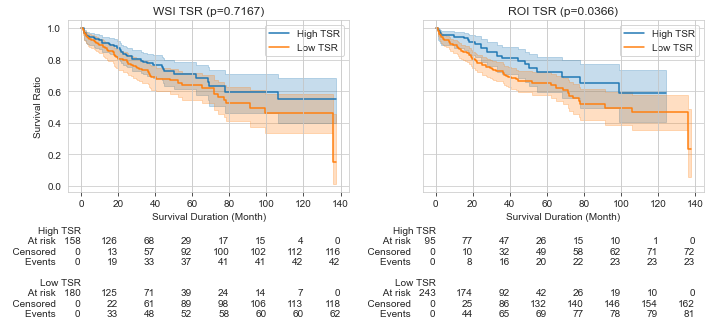

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
high_data = df[df.tsr_agg == 'High'].dropna(subset=['os'])
high_data['os_event'] = encoders['os_event'].transform(high_data.os_event)
low_data = df[df.tsr_agg == 'Low'].dropna(subset=['os'])
low_data['os_event'] = encoders['os_event'].transform(low_data.os_event)

model_low = KaplanMeierFitter().fit(high_data.os, high_data.os_event, label='High TSR')
model_high = KaplanMeierFitter().fit(low_data.os, low_data.os_event, label='Low TSR')

model_low.plot(ax=axs[0])
model_high.plot(ax=axs[0])
add_at_risk_counts(model_low, model_high, ax=axs[0])

res = ttest_ind(low_data.os, high_data.os)
axs[0].set_title(f'WSI TSR (p={res.pvalue:.4f})')
axs[0].set_xlabel('Survival Duration (Month)')
axs[0].set_ylabel('Survival Ratio')

high_data = df[df.roi_tsr_agg == 'High'].dropna(subset=['os'])
high_data['os_event'] = encoders['os_event'].transform(high_data.os_event)
low_data = df[df.roi_tsr_agg == 'Low'].dropna(subset=['os'])
low_data['os_event'] = encoders['os_event'].transform(low_data.os_event)

model_low = KaplanMeierFitter().fit(high_data.os, high_data.os_event, label='High TSR')
model_high = KaplanMeierFitter().fit(low_data.os, low_data.os_event, label='Low TSR')

model_low.plot(ax=axs[1])
model_high.plot(ax=axs[1])
add_at_risk_counts(model_low, model_high, ax=axs[1])

res = ttest_ind(low_data.os, high_data.os)
axs[1].set_title(f'ROI TSR (p={res.pvalue:.4f})')
axs[1].set_xlabel('Survival Duration (Month)')
# axs[1].set_ylabel('Survival Ratio')

plt.tight_layout()
plt.savefig('figures/Kaplan-Meier.pdf')
plt.show()

# res = ttest_ind(low_data.os, high_data.os)
# print('%.4f' % res.pvalue)

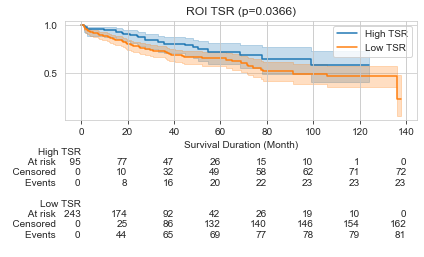

In [12]:
high_data = df[df.roi_tsr_agg == 'High'].dropna(subset=['os'])
high_data['os_event'] = encoders['os_event'].transform(high_data.os_event)
low_data = df[df.roi_tsr_agg == 'Low'].dropna(subset=['os'])
low_data['os_event'] = encoders['os_event'].transform(low_data.os_event)

model_low = KaplanMeierFitter().fit(high_data.os, high_data.os_event, label='High TSR')
model_high = KaplanMeierFitter().fit(low_data.os, low_data.os_event, label='Low TSR')

ax = model_low.plot()
model_high.plot(ax=ax)
add_at_risk_counts(model_low, model_high, ax=ax)

res = ttest_ind(low_data.os, high_data.os)
ax.set_title(f'ROI TSR (p={res.pvalue:.4f})')
ax.set_xlabel('Survival Duration (Month)')
# axs[1].set_ylabel('Survival Ratio')

plt.tight_layout()
plt.savefig('figures/Kaplan-Meier-single.png', bbox_inches='tight')
plt.show()

In [375]:
univar_results = {}
data = df.copy()
data['os_event'] = encoders['os_event'].transform(data.os_event)
for col in ['pn_group', 'tnm_group', 'pt_group', 'tsr_agg', 'roi_tsr_agg', 'pm', 'tbc']:
    univar_data = data[['os', 'os_event', col]].dropna()
    if col in encoders:
        univar_data[col] = encoders[col].transform(univar_data[col])
    univar_model = CoxPHFitter().fit(univar_data, duration_col='os', event_col='os_event')
    # univar_results[col] = [univar_model.params_.iloc[0], *univar_model.confidence_intervals_.iloc[0,:].values]
    # res = univar_model.log_likelihood_ratio_test()
    # univar_results[col].append(res.p_value)
    univar_results[col] = univar_model.summary.squeeze()
    univar_results[col]['N'] = univar_data.shape[0]


In [377]:
results = pd.DataFrame(univar_results).T

results.to_csv(os.path.join(Abed_utils.OUTPUT_ROOT, 'univar_resutlts.csv'), index_label='Feature')
results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),N
pn_group,1.062987,2.895006,0.212688,0.646127,1.479847,1.908136,4.392275,0.0,4.997878,5.796449e-07,20.718327,331.0
tnm_group,0.954849,2.598279,0.212748,0.537872,1.371827,1.712359,3.942547,0.0,4.488181,7.183396e-06,17.086903,336.0
pt_group,0.701011,2.015789,0.319568,0.074670,1.327351,1.077528,3.771042,0.0,2.193623,2.826255e-02,5.144964,337.0
tsr_agg,0.286612,1.331907,0.200317,-0.106001,0.679225,0.899424,1.972349,0.0,1.430796,1.524888e-01,2.713225,338.0
roi_tsr_agg,0.466377,1.594208,0.237308,0.001262,0.931491,1.001263,2.538292,0.0,1.965283,4.938153e-02,4.339885,338.0
pm,0.565229,1.759851,0.288367,0.000040,1.130419,1.000040,3.096954,0.0,1.960102,4.998387e-02,4.322394,338.0
tbc,-0.600701,0.548427,0.259116,-1.108560,-0.092842,0.330034,0.911337,0.0,-2.318268,2.043476e-02,5.612831,246.0


In [378]:
p_thresh = 5e-2
significant_features = results[results.p <= p_thresh]
significant_features

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),N
pn_group,1.062987,2.895006,0.212688,0.646127,1.479847,1.908136,4.392275,0.0,4.997878,5.796449e-07,20.718327,331.0
tnm_group,0.954849,2.598279,0.212748,0.537872,1.371827,1.712359,3.942547,0.0,4.488181,7.183396e-06,17.086903,336.0
pt_group,0.701011,2.015789,0.319568,0.074670,1.327351,1.077528,3.771042,0.0,2.193623,2.826255e-02,5.144964,337.0
roi_tsr_agg,0.466377,1.594208,0.237308,0.001262,0.931491,1.001263,2.538292,0.0,1.965283,4.938153e-02,4.339885,338.0
pm,0.565229,1.759851,0.288367,0.000040,1.130419,1.000040,3.096954,0.0,1.960102,4.998387e-02,4.322394,338.0
tbc,-0.600701,0.548427,0.259116,-1.108560,-0.092842,0.330034,0.911337,0.0,-2.318268,2.043476e-02,5.612831,246.0


In [379]:
bivar_results = {}
data = df.copy()
data['os_event'] = encoders['os_event'].transform(data.os_event)
features = ['pn_group', 'tnm_group', 'tbc', 'pt_group', 'tsr_agg', 'roi_tsr_agg']
for col in features:
    features_2nd = features.copy()
    features_2nd.remove(col)
    bivar_results[col] = {}
    for col2 in features_2nd:
        if col2 in bivar_results and col in bivar_results[col2]:
            bivar_results[col][col2]= bivar_results[col2][col]
            continue
        bivar_data = data[['os', 'os_event', col, col2]].dropna()
        if col in encoders:
            bivar_data[col] = encoders[col].transform(bivar_data[col])
        if col2 in encoders:
            bivar_data[col2] = encoders[col2].transform(bivar_data[col2])
        bivar_model = CoxPHFitter().fit(bivar_data, duration_col='os', event_col='os_event')
        # break
        bivar_results[col][col2] = bivar_model.summary

In [380]:
bivar_results['tnm_group']['pn_group']

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pn_group,17.071584,2.594745e+07,2141.612660,-4180.412099,4214.555267,0.0,inf,0.0,0.007971,0.993640,0.009205
tnm_group,-16.071662,1.047529e-07,2141.612664,-4213.555353,4181.412029,0.0,inf,0.0,-0.007504,0.994012,0.008664


In [381]:
pair = df[['pn_group', 'tnm_group']].dropna()
for col in pair:
    pair[col] = encoders[col].transform(pair[col])
pair[pair.pn_group != pair.tnm_group]

,pn_group,tnm_group
121,0,1
128,0,1
152,0,1
233,0,1
260,0,1
269,0,1
289,0,1
442,0,1
502,0,1
611,0,1


In [382]:
cols = significant_features.index.tolist()
grouped_data = df[cols+['os', 'os_event']].dropna().drop(['tnm_group'], axis=1)
for col in grouped_data:
    if col in encoders:
        grouped_data[col] = encoders[col].transform(grouped_data[col])

grouped_model = CoxPHFitter().fit(grouped_data, duration_col='os', event_col='os_event')
grouped_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pn_group,0.826906,2.286235,0.255865,0.325420,1.328392,1.384612,3.774969,0.0,3.231808,0.001230,9.667013
pt_group,-0.090371,0.913593,0.375688,-0.826705,0.645963,0.437489,1.907824,0.0,-0.240547,0.809906,0.304173
roi_tsr_agg,0.197706,1.218604,0.274344,-0.339999,0.735410,0.711771,2.086337,0.0,0.720649,0.471126,1.085816
pm,0.155468,1.168204,0.369249,-0.568248,0.879183,0.566517,2.408932,0.0,0.421038,0.673728,0.569762
tbc,-0.395827,0.673123,0.274234,-0.933317,0.141662,0.393247,1.152187,0.0,-1.443391,0.148910,2.747484


In [388]:
grouped_model.summary.loc['roi_tsr_agg']

coef                   0.197706
exp(coef)              1.218604
se(coef)               0.274344
coef lower 95%        -0.339999
coef upper 95%         0.735410
exp(coef) lower 95%    0.711771
exp(coef) upper 95%    2.086337
cmp to                 0.000000
z                      0.720649
p                      0.471126
-log2(p)               1.085816
Name: roi_tsr_agg, dtype: float64

In [389]:
base_model = CoxPHFitter().fit(grouped_data.drop('roi_tsr_agg', axis=1).dropna(), duration_col='os', event_col='os_event')
base_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pn_group,0.852765,2.346126,0.253197,0.356509,1.349022,1.428335,3.853653,0.0,3.367997,0.000757,10.367107
pt_group,-0.037262,0.963423,0.367658,-0.757859,0.683334,0.468669,1.980469,0.0,-0.101351,0.919272,0.121436
pm,0.135001,1.144538,0.368195,-0.586649,0.856650,0.556188,2.355258,0.0,0.366655,0.713876,0.486254
tbc,-0.391771,0.675859,0.273254,-0.927338,0.143797,0.395605,1.154650,0.0,-1.433724,0.151651,2.721173


In [265]:
base_ll = base_model.log_likelihood_ratio_test()
aug_ll = grouped_model.log_likelihood_ratio_test()

print(base_ll, '\n++++++++++++++++++++\n', aug_ll)

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 3
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          28.25 <0.005     18.24 
++++++++++++++++++++
 <lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 4
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          29.40 <0.005     17.23


In [266]:
grouped_model.check_assumptions(grouped_data)

Proportional hazard assumption looks okay.


C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


[]

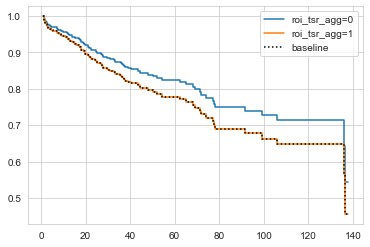

In [267]:
grouped_model.plot_partial_effects_on_outcome('roi_tsr_agg', values=[0, 1])
plt.show()

In [268]:
encoders['roi_tsr_agg'].inverse_transform([])

array([], dtype=float64)

In [269]:
viz_df = full_df.copy()
# print(viz_df.dtypes)
# viz_df['tsr'] = (viz_df.tsr >= 0.5).map({True: 'High', False:'Low'})
# viz_df['roi_tsr'] = (viz_df.roi_tsr >= 0.5).map({True: 'High', False:'Low'})

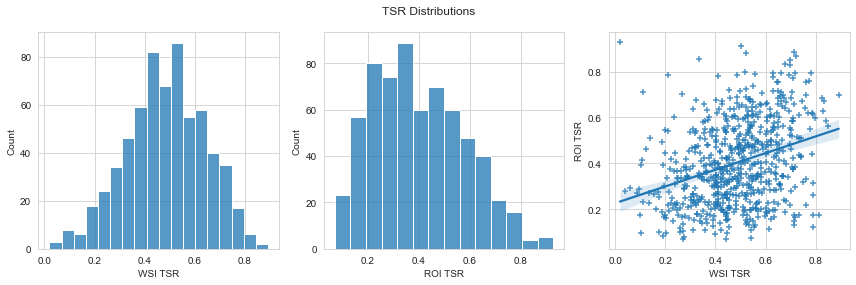

In [270]:
cols = ['tsr', 'roi_tsr']
lbls = ['WSI TSR', 'ROI TSR']
fig, axs = plt.subplots(1, len(cols)+1, figsize=(4*len(cols)+4,4))
fig.suptitle('TSR Distributions')

for col, ax, lbl in zip(cols, axs, lbls):
    sns.histplot(data=full_df, x=col, ax=ax)
    ax.set_xlabel(lbl)
sns.regplot(data=viz_df, x='tsr', y='roi_tsr', ax=axs[2], marker='+')
axs[2].set_xlabel('WSI TSR')
axs[2].set_ylabel('ROI TSR')
plt.tight_layout()
plt.savefig('figures/TSR_distribution_all.pdf')
plt.show()

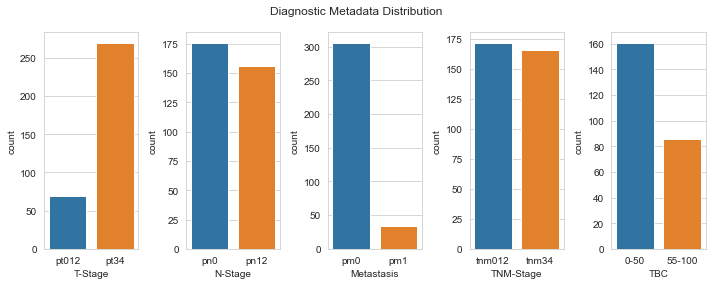

In [293]:
cols = ['pt_group', 'pn_group', 'pm', 'tnm_group', 'tbc']
lbls = ['T-Stage', 'N-Stage', 'Metastasis', 'TNM-Stage', 'TBC']
fig, axs = plt.subplots(1, len(cols), figsize=(2*len(cols),4))
fig.suptitle('Diagnostic Metadata Distribution')

for col, ax, lbl in zip(cols, axs, lbls):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_xlabel(lbl)
plt.tight_layout()
plt.savefig('figures/stage_distribution.pdf')
plt.show()

In [272]:
diff_df = full_df[['slide_filename', 'roi_tsr', 'tsr']].copy()
diff_df['tsr_diff'] = abs(diff_df.roi_tsr - diff_df.tsr)
diff_df.drop(['tsr', 'roi_tsr'], axis=1, inplace=True)
diff_df.sort_values('tsr_diff', ascending=False, inplace=True)
diff_df.head()

,slide_filename,tsr_diff
543,844_B2014.44442_J_HE.mrxs,0.909092
305,576b_B2012.29624_F_HE.mrxs,0.667835
482,755b_B2014.5672_C_HE.mrxs,0.635416
383,660b_B2013.44754_E_HE.mrxs,0.614709
222,407c_B2009.29962_II-i_HE.mrxs,0.597086


In [273]:
wsi_suffix = '_seg_dino_imagenet_100ep_KNN.npy'
roi_suffix = '.csv'
wsi_pred_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'predictions_KNN')
roi_pred_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'roi_final_act4', 'out')

In [274]:
i = 0
fname = diff_df.iloc[i].slide_filename
wsi_preds = np.load(os.path.join(wsi_pred_path, fname+wsi_suffix), allow_pickle=True).item()
roi_preds = pd.read_csv(os.path.join(roi_pred_path, fname+roi_suffix)).reset_index()

map = Abed_utils.build_prediction_map(coords_x=wsi_preds['metadata'][:,3],
                                      coords_y=wsi_preds['metadata'][:,4],
                                      feature=wsi_preds['classification'][:,None])

plt.imshow(map)

IndexError: index 375 is out of bounds for axis 0 with size 375

In [ ]:
cmap = Abed_utils.build_disrete_cmap('kather19', background=[[1, 1, 1]])

In [299]:
grouped_model.predict_survival_function(np.array([[0,1,0,1],
                                                  [1,1,1,1]]))

,0,1
1.084813,0.998398,0.994478
1.117686,0.998398,0.994478
1.183432,0.998398,0.994478
1.282051,0.996783,0.988934
1.380671,0.995159,0.983382
...,...,...
133.234714,0.677315,0.260441
135.174227,0.677315,0.260441
136.061801,0.599412,0.170793
136.193294,0.494658,0.087986


In [302]:
corr_data = df[['pn_group', 'tnm_group']].copy().dropna()
for col in corr_data:
    if col in encoders:
        corr_data[col] = encoders[col].transform(corr_data[col])

corr_data.corr()

,pn_group,tnm_group
pn_group,1.000000,0.941469
tnm_group,0.941469,1.000000
